# Assignment 4: Convolutional Neural Networks

In [1]:
import json
import os
import sys
import shutil
from typing import Literal, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
import wandb

PROJECT_DIR = '../..'
sys.path.insert(0, PROJECT_DIR)

from models.cnn import CNN

## Classification using CNN

### Data Loading and Preprocessing

In [2]:
def load_mnist_data(
    dataset_path: str, split: Literal['train', 'val', 'test'], count_digits: bool = False
) -> Tuple[npt.NDArray[float], npt.NDArray[str | int]]:
    """ Loads the images and labels for a split of the Multi MNIST (double_mnist) dataset. """

    # Image, label pairs
    X, y = [], []

    for descriptor in os.listdir(f'{dataset_path}/{split}'):

        # Label
        if count_digits:
            label = [len(descriptor)] if descriptor != '0' else [0]
        else:
            label = descriptor

        # Image
        for image_path in os.listdir(f'{dataset_path}/{split}/{descriptor}'):
            image = cv2.imread(f'{dataset_path}/{split}/{descriptor}/{image_path}', 0)
            image = image.astype(np.float32) / 255.0
            image = np.expand_dims(image, axis=0)

            # Store image and label
            X.append(image)
            y.append(label)

    return np.array(X), np.array(y)

def one_hot_encoding(labels: npt.NDArray[str]) -> npt.NDArray[float]:
    """ Creates one hot encoded vectors for each label value. """

    out = []
    for label in labels:
        encoding = np.zeros(10)
        if label != '0':
            encoding[[int(c) for c in label]] = 1
        out.append(encoding)
    return np.array(out)

In [3]:
class MultiMNISTDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str, split: Literal['train', 'val', 'test'], \
                                                                task: Literal['count', 'predict']):

        if task == 'count':
            self.images, self.labels = load_mnist_data(dataset_path, split, count_digits=True)
        else:
            self.images, self.labels = load_mnist_data(dataset_path, split, count_digits=False)
            self.labels = one_hot_encoding(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.Tensor(self.images[idx]), torch.Tensor(self.labels[idx])

In [4]:
train_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'train', 'count')
val_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'val', 'count')
test_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'test', 'count')

### Hyperparameter Tuning

In [5]:
def train_worker(task: Literal['regression', 'single-label-classification', 'multi-label-classification']):
    """ Trains a CNN for a given configuration. """

    wandb.init()
    cnn = CNN(
        task=task,
        activation='relu',
        pool='maxpool',
        dropout=wandb.config.dropout,
        lr=wandb.config.lr,
        num_blocks=wandb.config.num_blocks,
        optimizer=wandb.config.optimizer,
    )
    cnn.fit(train_dataset, val_dataset, wandb_log=True)

In [6]:
# def regression_train_worker():
#     train_worker(task='regression')

# regression_sweep_config = {
#     'name': 'regression-hyperparameter-tuning',
#     'method': 'grid',
#     'metric': { 'name': 'val_loss', 'goal': 'minimize' },
#     'parameters': {
#         'dropout': { 'values': [0, 0.2, 0.4] },
#         'lr': { 'values': [5e-4, 5e-3] },
#         'num_blocks': { 'values': [5, 7] },
#         'optimizer': { 'values': ['sgd', 'adam'] },
#     }
# }

# regression_sweep_id = wandb.sweep(regression_sweep_config, project='smai-m24-cnn')
# wandb.agent(regression_sweep_id, regression_train_worker)
# wandb.finish()
# shutil.rmtree('wandb')

In [7]:
with open(f'{PROJECT_DIR}/assignments/4/results/cnn_regression_hyperparameters.json', \
                                                                'r', encoding='utf-8') as file:
    config = json.load(file)

regression_cnn = CNN(
    task='regression',
    activation='relu',
    pool='maxpool',
    dropout=config['dropout'],
    lr=config['lr'],
    num_blocks=config['num_blocks'],
    optimizer=config['optimizer']
)
regression_cnn.fit(train_dataset, val_dataset, verbose=True)
print()

val_pred = regression_cnn.predict(val_dataset)
val_acc = (val_pred == val_dataset[:][1]).float().mean()
print(f'Validation accuracy: {val_acc}')

test_pred = regression_cnn.predict(test_dataset)
test_acc = (test_pred == test_dataset[:][1]).float().mean()
print(f'Test accuracy: {test_acc}')

Epoch 0, Train Loss: 0.609702481316204, Val Loss: 0.01149250659348562
Epoch 1, Train Loss: 0.05839376560965468, Val Loss: 0.004546114018321919
Epoch 2, Train Loss: 0.04359004385816642, Val Loss: 0.005193696848436957
Epoch 3, Train Loss: 0.041170530763412184, Val Loss: 0.0022974094411031903
Epoch 4, Train Loss: 0.03678345917322233, Val Loss: 0.0008012837022258108
Epoch 5, Train Loss: 0.03441971160830731, Val Loss: 0.0009118563533039823
Epoch 6, Train Loss: 0.03303103756424285, Val Loss: 0.0004267788112980618
Epoch 7, Train Loss: 0.030902841303327364, Val Loss: 0.000821285183684132
Epoch 8, Train Loss: 0.029494276839937203, Val Loss: 0.003558495383448973

Validation accuracy: 1.0
Test accuracy: 1.0


In [8]:
# def single_label_classification_train_worker():
#     train_worker(task='single-label-classification')

# single_label_classification_sweep_config = {
#     'name': 'single-label-classification-hyperparameter-tuning',
#     'method': 'grid',
#     'metric': { 'name': 'val_loss', 'goal': 'minimize' },
#     'parameters': {
#         'dropout': { 'values': [0, 0.2, 0.4] },
#         'lr': { 'values': [5e-5, 5e-4] },
#         'num_blocks': { 'values': [2, 4] },
#         'optimizer': { 'values': ['sgd', 'adam'] },
#     }
# }

# single_label_classification_sweep_id = wandb.sweep(single_label_classification_sweep_config, project='smai-m24-cnn')
# wandb.agent(single_label_classification_sweep_id, single_label_classification_train_worker)
# wandb.finish()
# shutil.rmtree('wandb')

In [9]:
with open(f'{PROJECT_DIR}/assignments/4/results/cnn_single_label_classification_hyperparameters.json', \
                                                                'r', encoding='utf-8') as file:
    config = json.load(file)

classification_cnn = CNN(
    task='single-label-classification',
    activation='relu',
    pool='maxpool',
    dropout=config['dropout'],
    lr=config['lr'],
    num_blocks=config['num_blocks'],
    optimizer=config['optimizer']
)
classification_cnn.fit(train_dataset, val_dataset, verbose=True)
print()

val_pred = classification_cnn.predict(val_dataset)
val_acc = (val_pred == val_dataset[:][1]).float().mean()
print(f'Validation accuracy: {val_acc}')

test_pred = classification_cnn.predict(test_dataset)
test_acc = (test_pred == test_dataset[:][1]).float().mean()
print(f'Test accuracy: {test_acc}')

Epoch 0, Train Loss: 1.110575375974481, Val Loss: 0.8114387900271314
Epoch 1, Train Loss: 0.8250303064203505, Val Loss: 0.8013231551393549
Epoch 2, Train Loss: 0.8198198370522048, Val Loss: 0.7988468706607819
Epoch 3, Train Loss: 0.8182693095074087, Val Loss: 0.7972005161833255
Epoch 4, Train Loss: 0.7942373434904263, Val Loss: 0.7490082991884109
Epoch 5, Train Loss: 0.7508725903663539, Val Loss: 0.7438787431158917
Epoch 6, Train Loss: 0.7456574134415176, Val Loss: 0.7437717299512092
Epoch 7, Train Loss: 0.7450220849610827, Val Loss: 0.7436695067172355
Epoch 8, Train Loss: 0.7450364911314195, Val Loss: 0.7439943323744104

Validation accuracy: 0.999666690826416
Test accuracy: 1.0


### Feature Map Visualization

In [10]:
def visualize_feature_maps(feature_maps: npt.NDArray[float], image_idx: int, num_blocks: int, num_cols: int = 16):

    for block_idx in range(num_blocks):
        num_maps = feature_maps[block_idx][image_idx].shape[0]
        num_rows = num_maps // num_cols

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows))
        fig.suptitle(f'Feature Map: Block {block_idx}')

        for map_idx in range(num_maps):
            r = map_idx // num_cols
            c = map_idx % num_cols
            axs[r][c].imshow(feature_maps[block_idx][image_idx, map_idx], cmap='gray')
            axs[r][c].axis('off')

        plt.tight_layout()
        plt.show()

In [11]:
feature_maps = regression_cnn.feature_maps(test_dataset[:3][0])

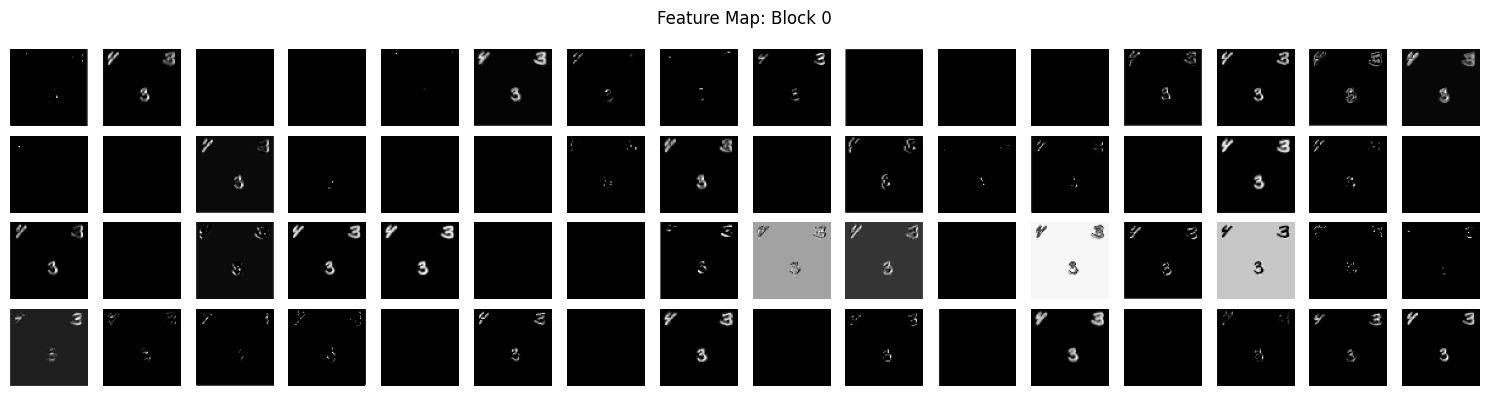

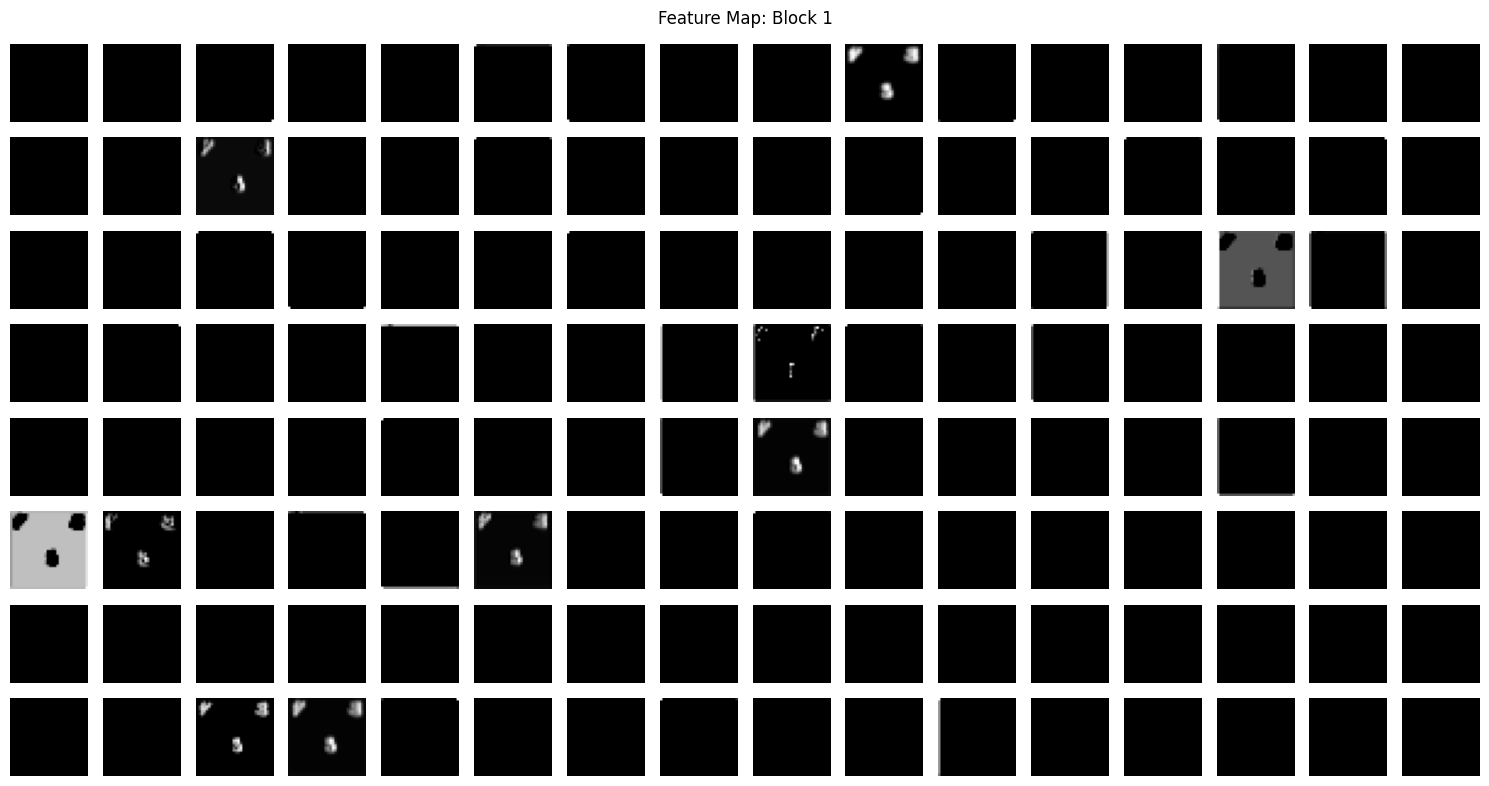

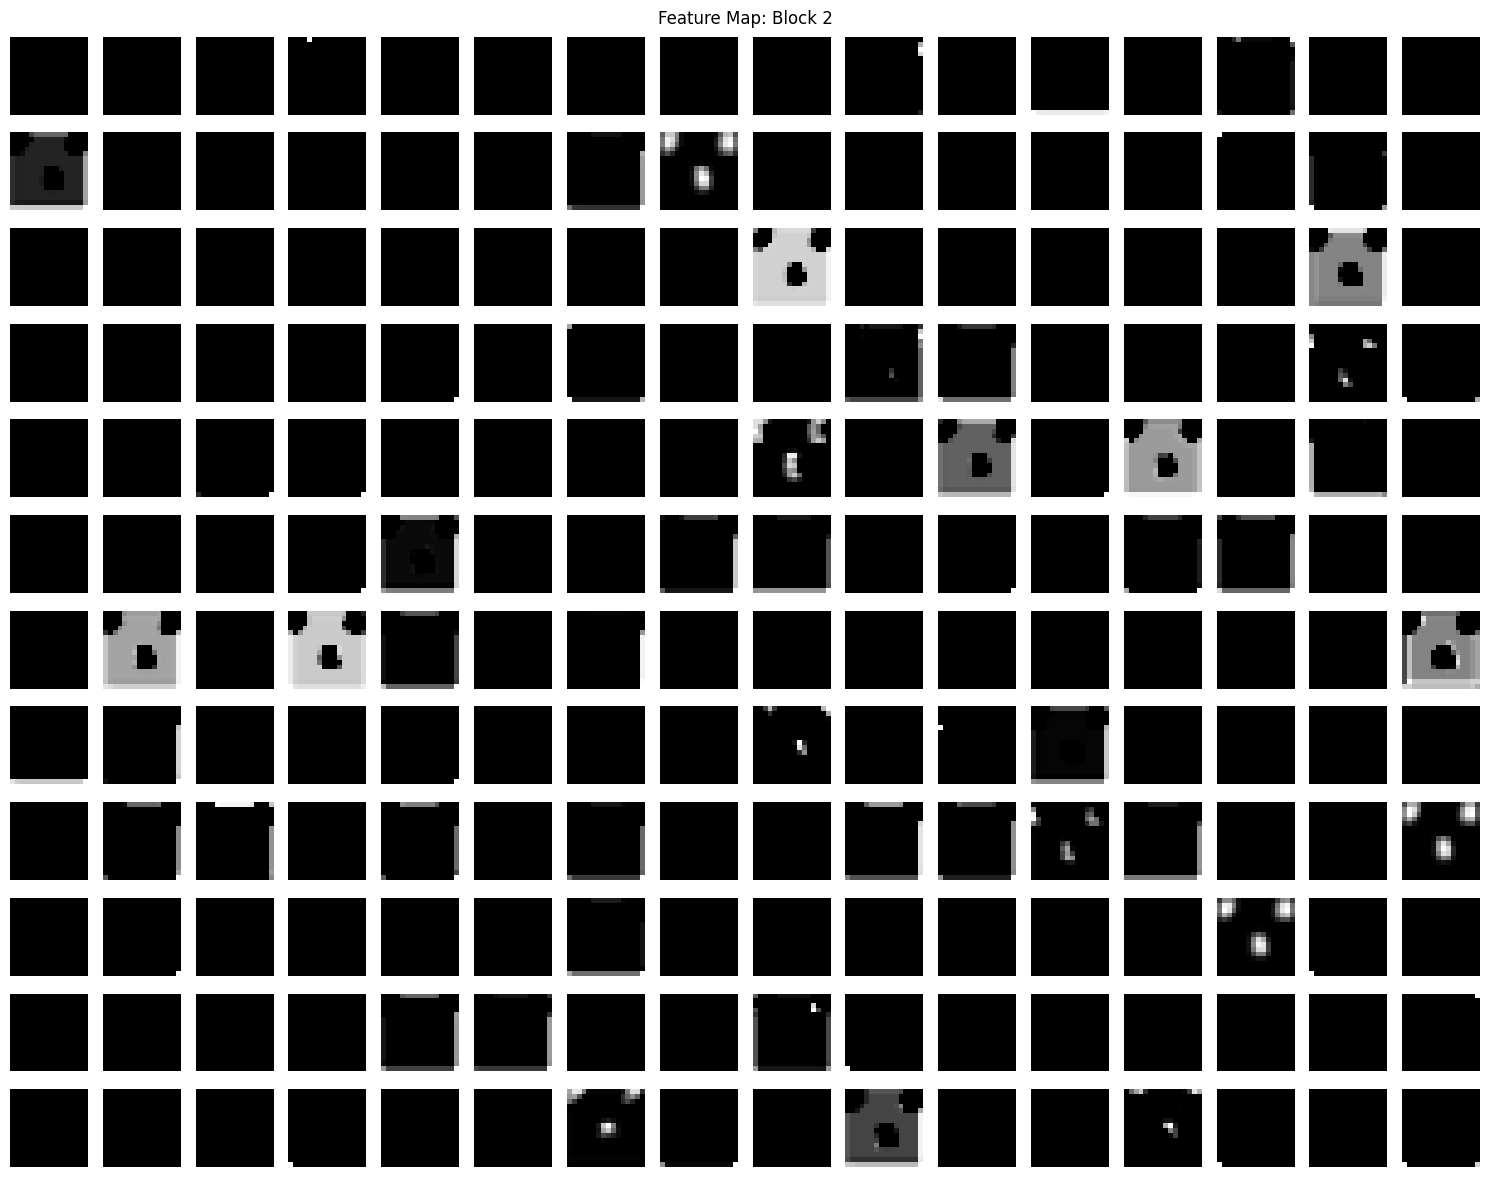

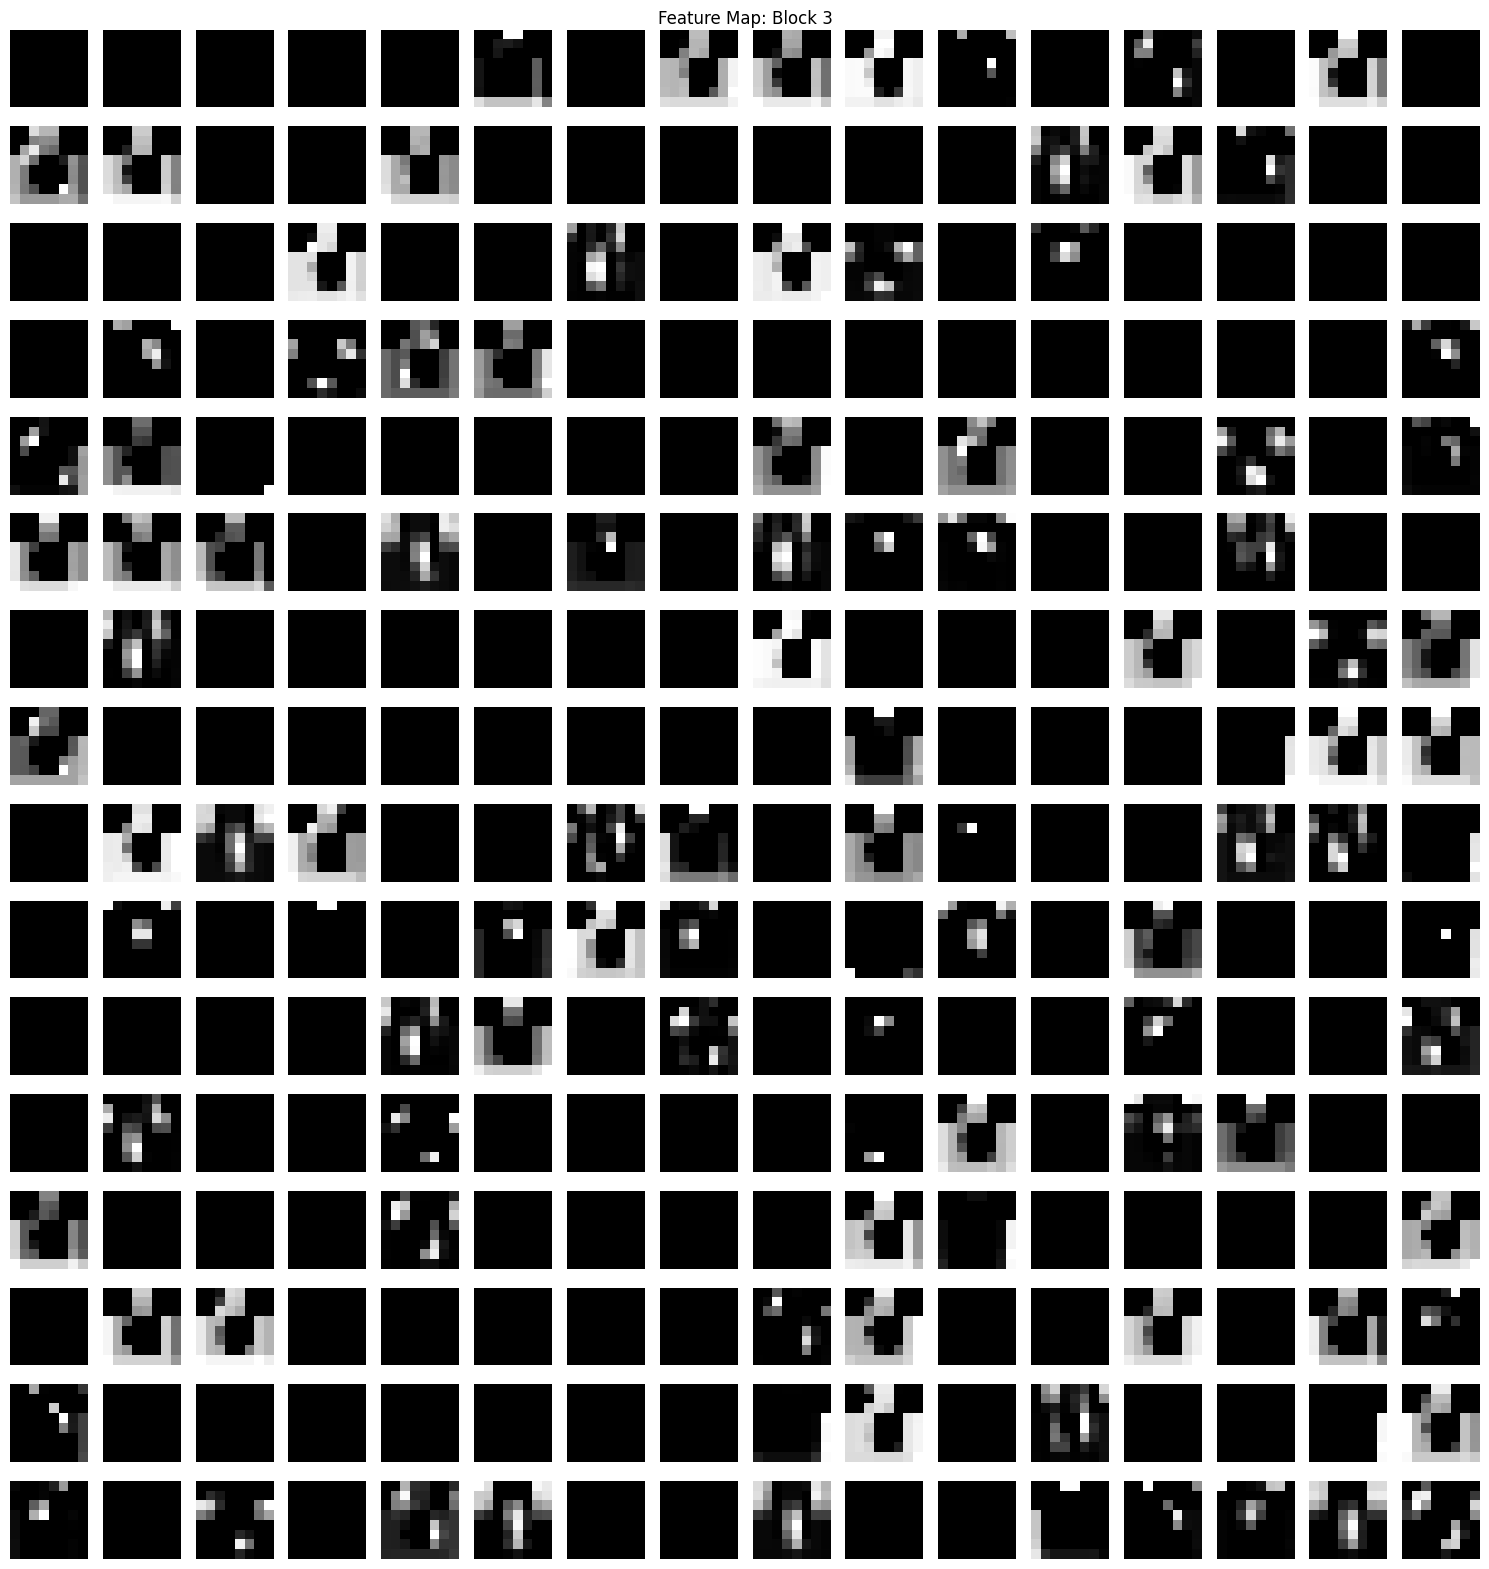

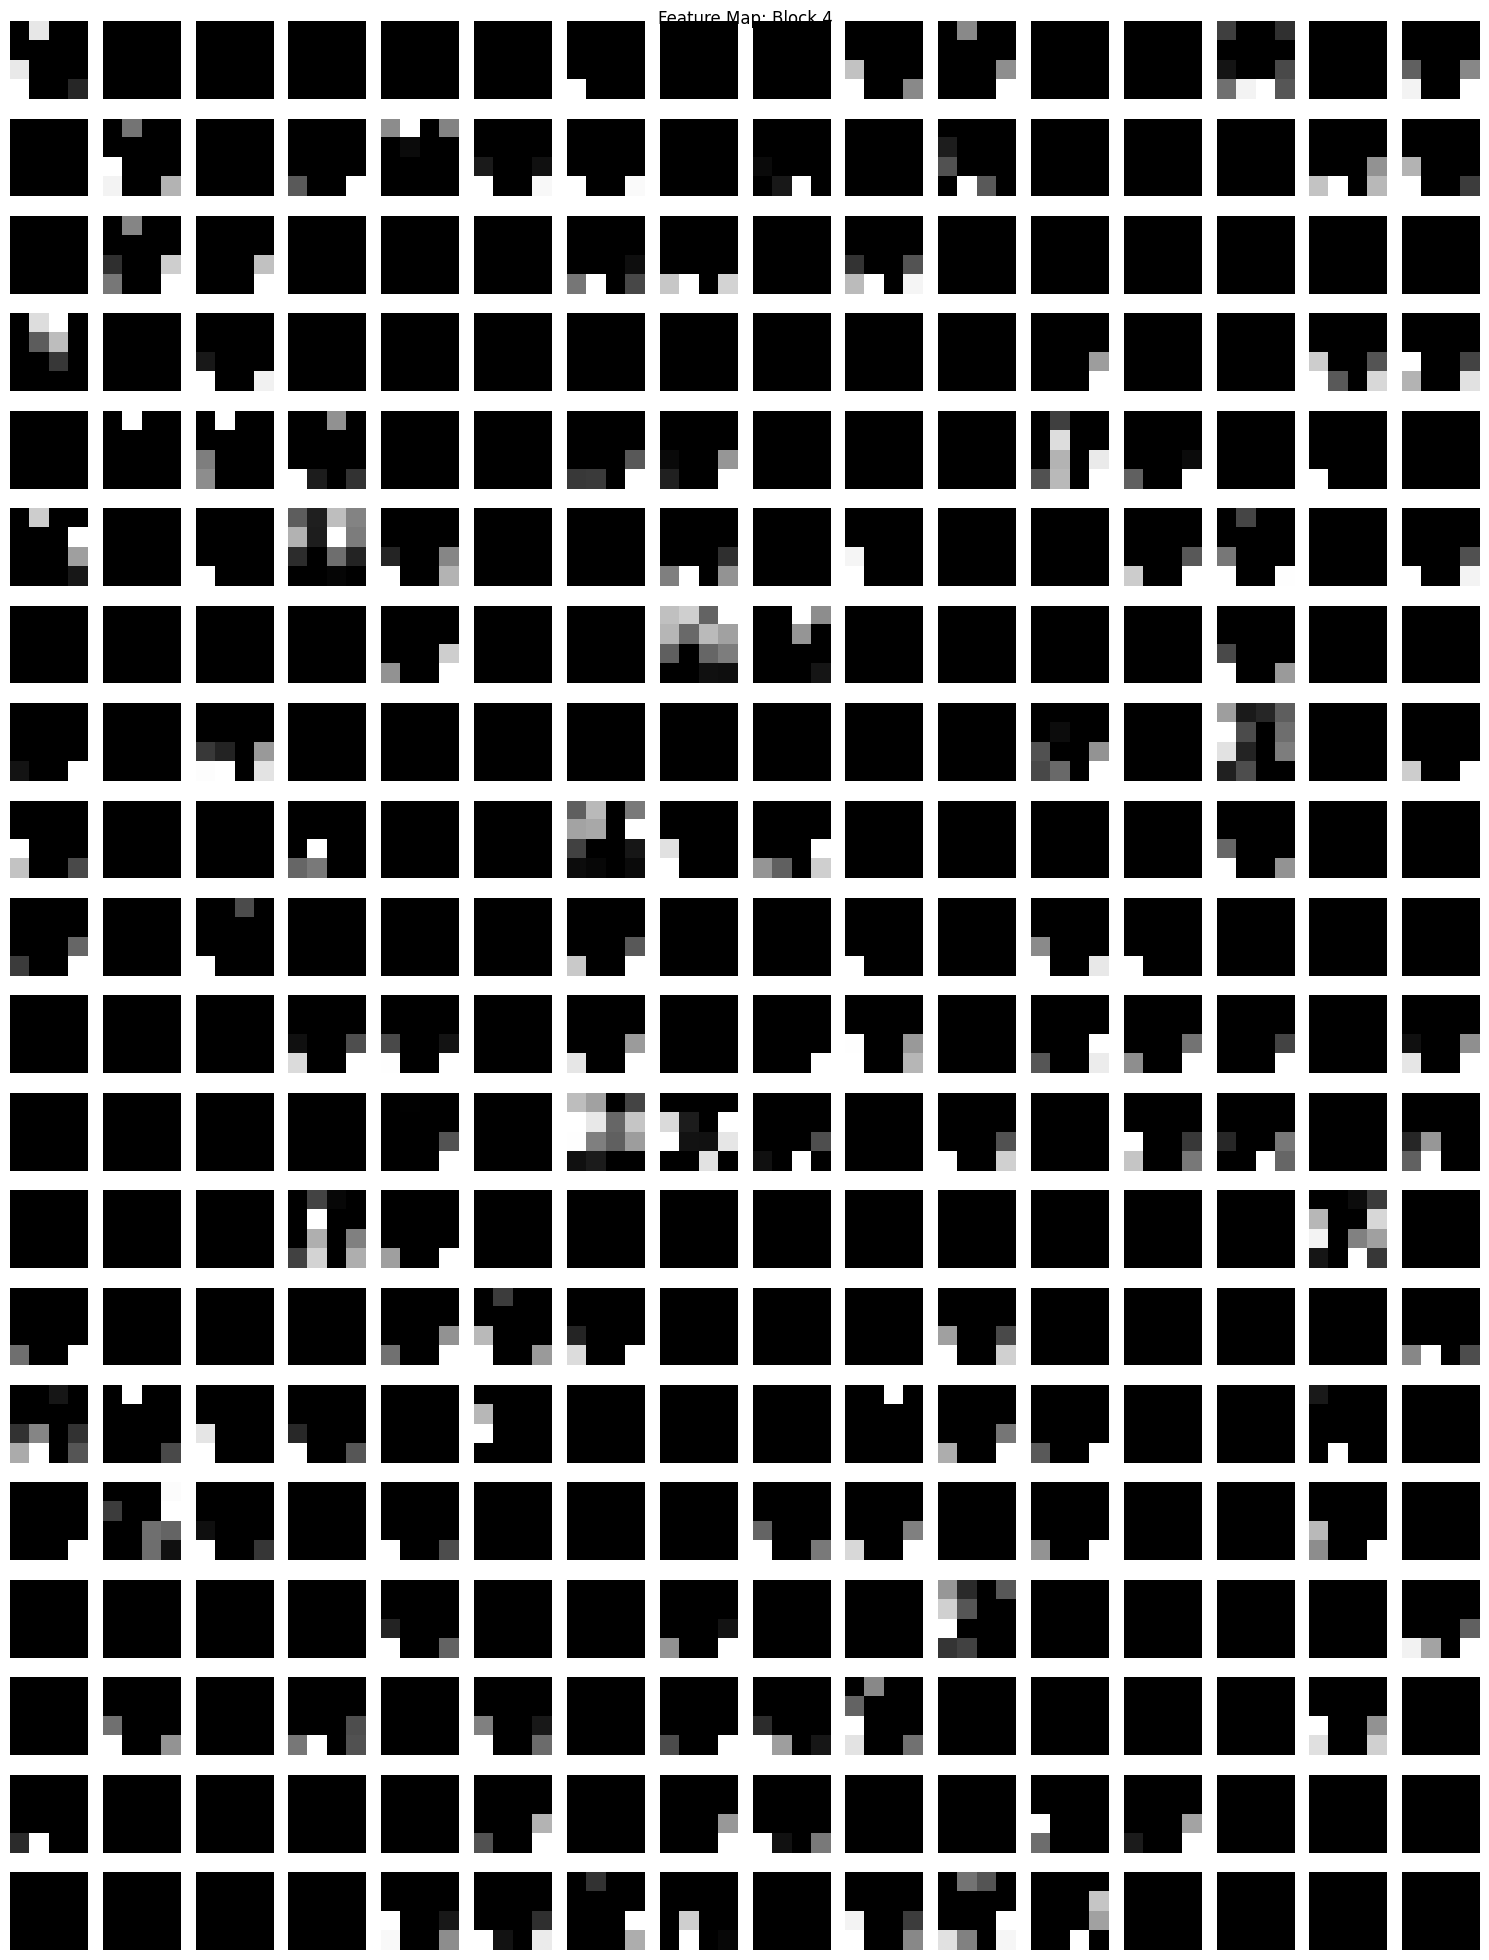

In [12]:
visualize_feature_maps(feature_maps, image_idx=0, num_blocks=5)

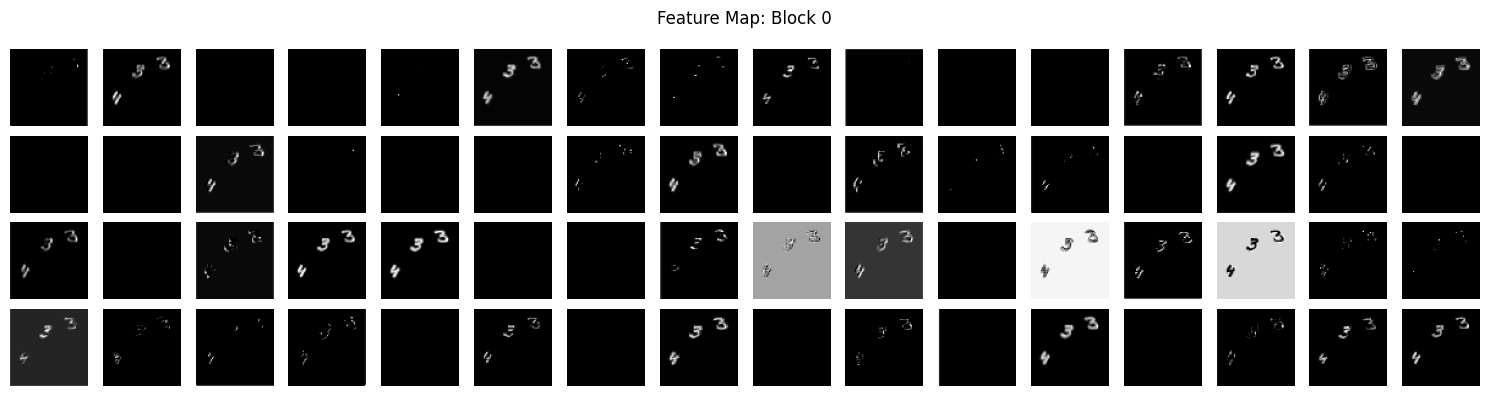

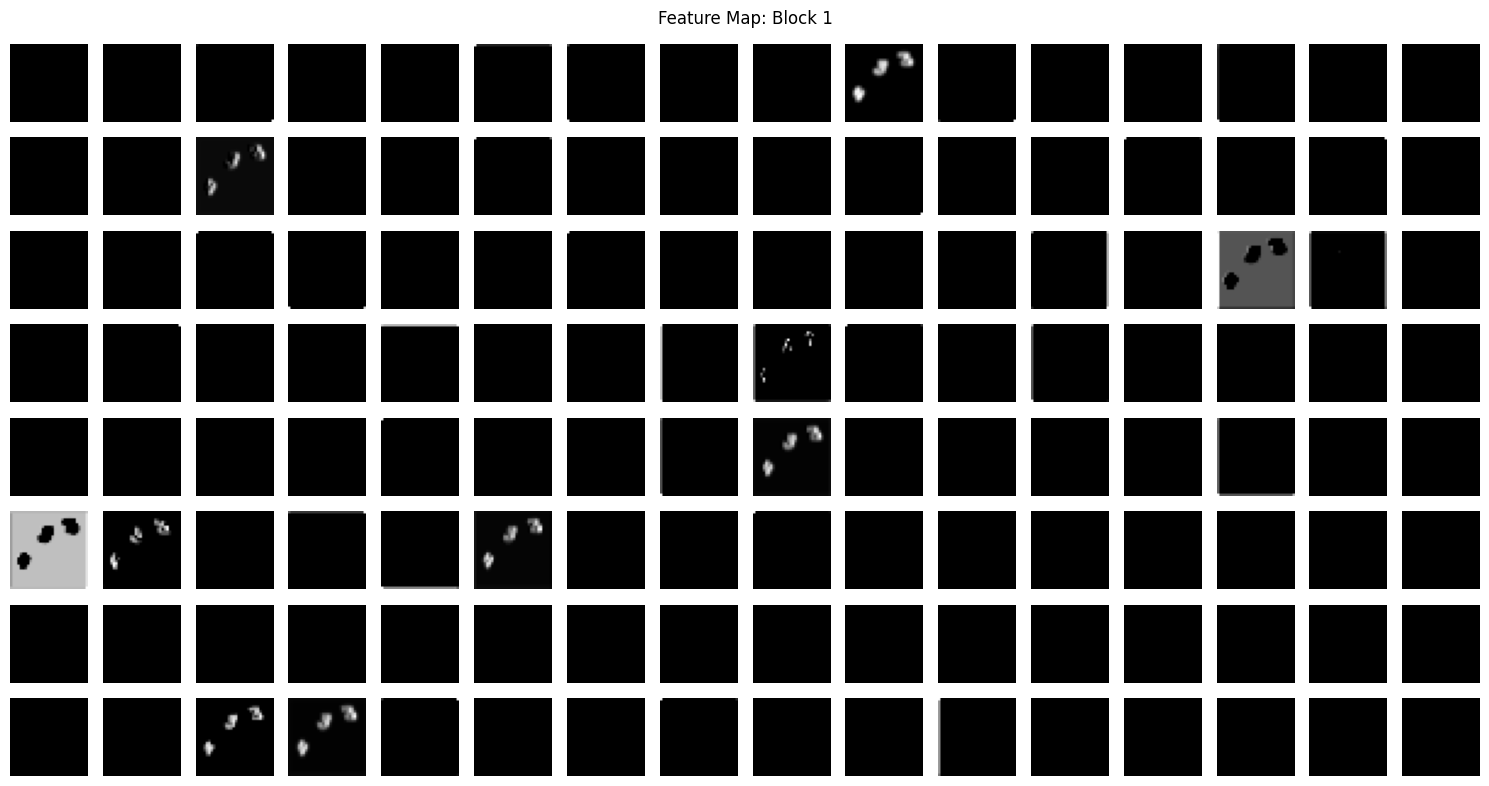

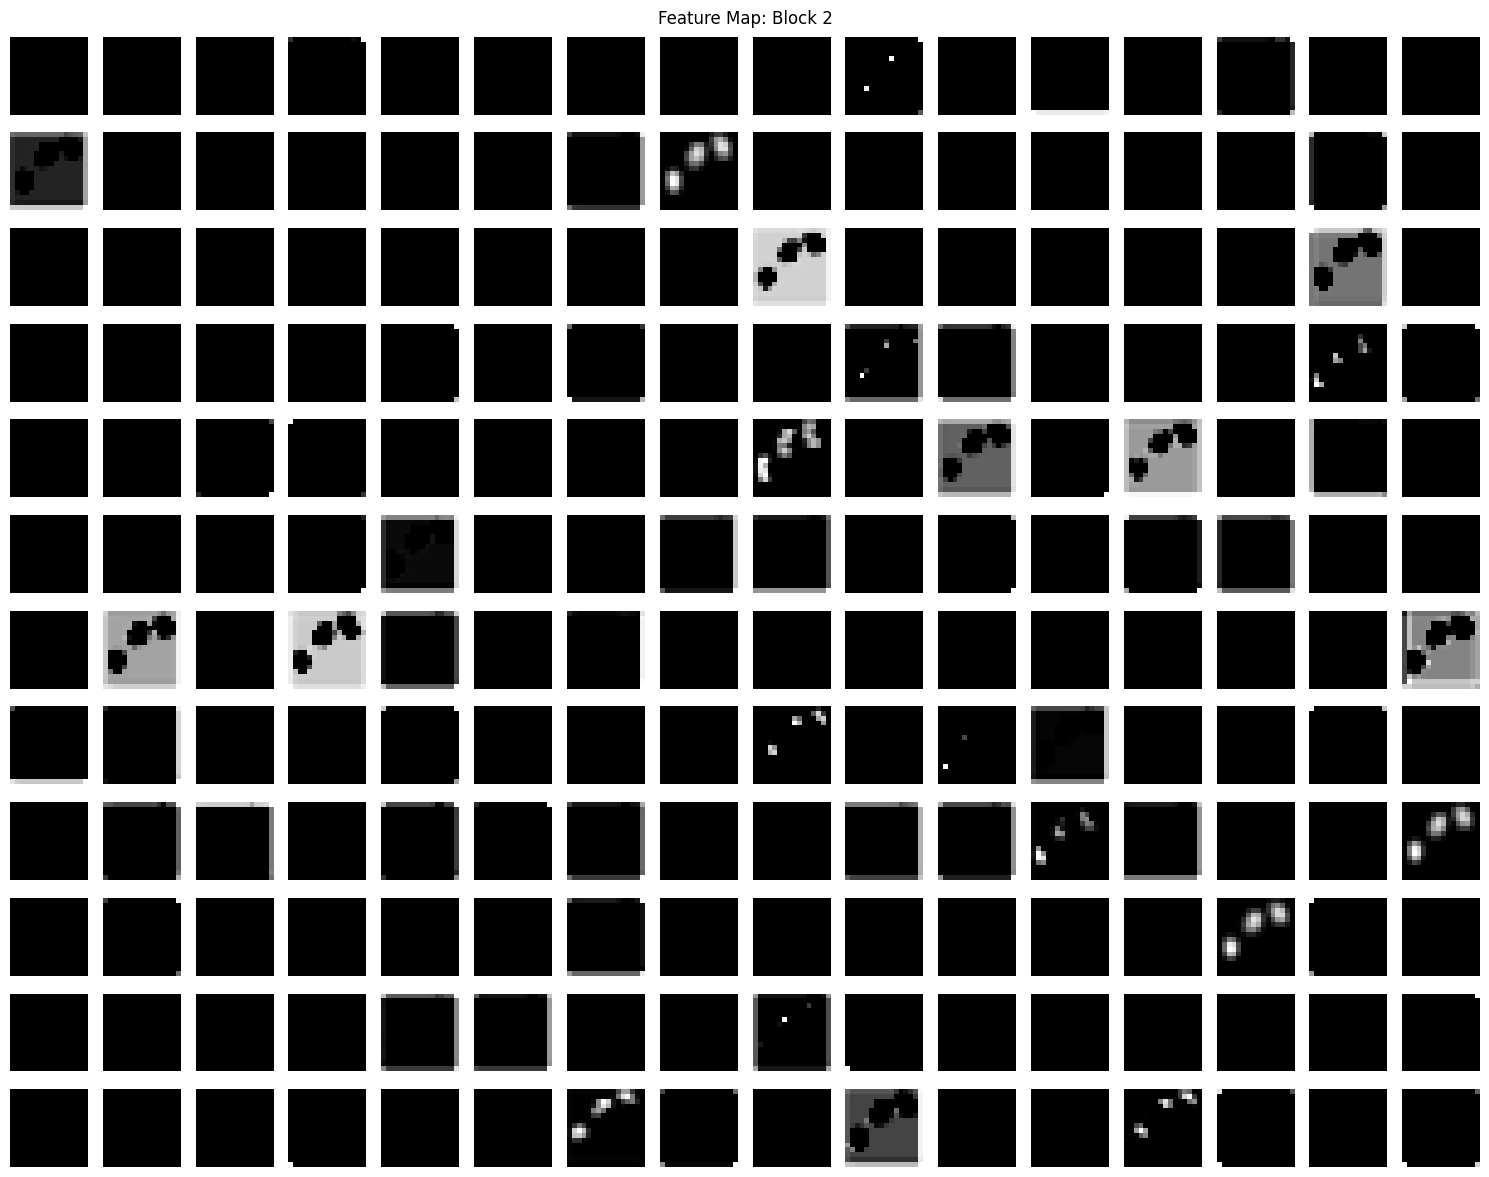

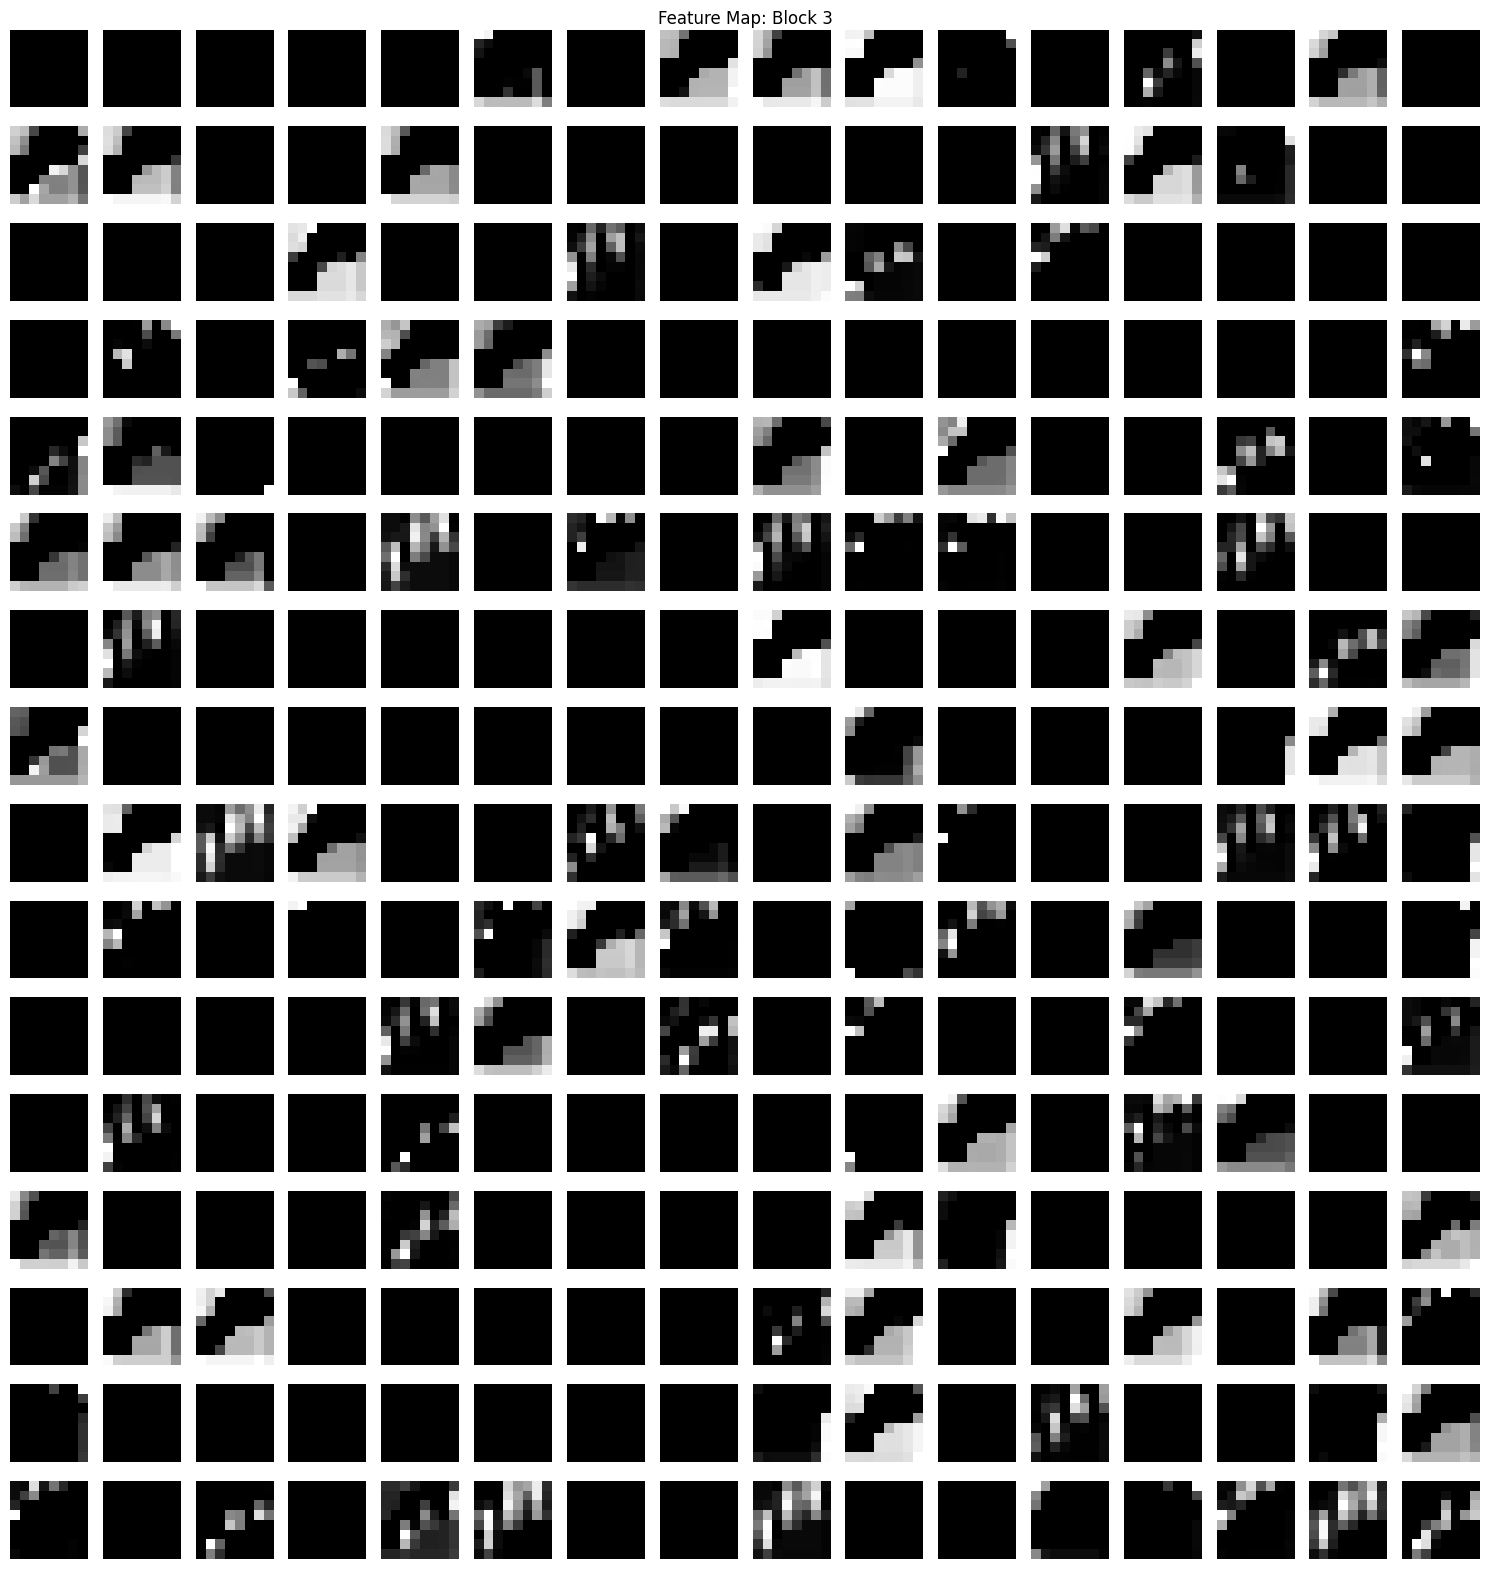

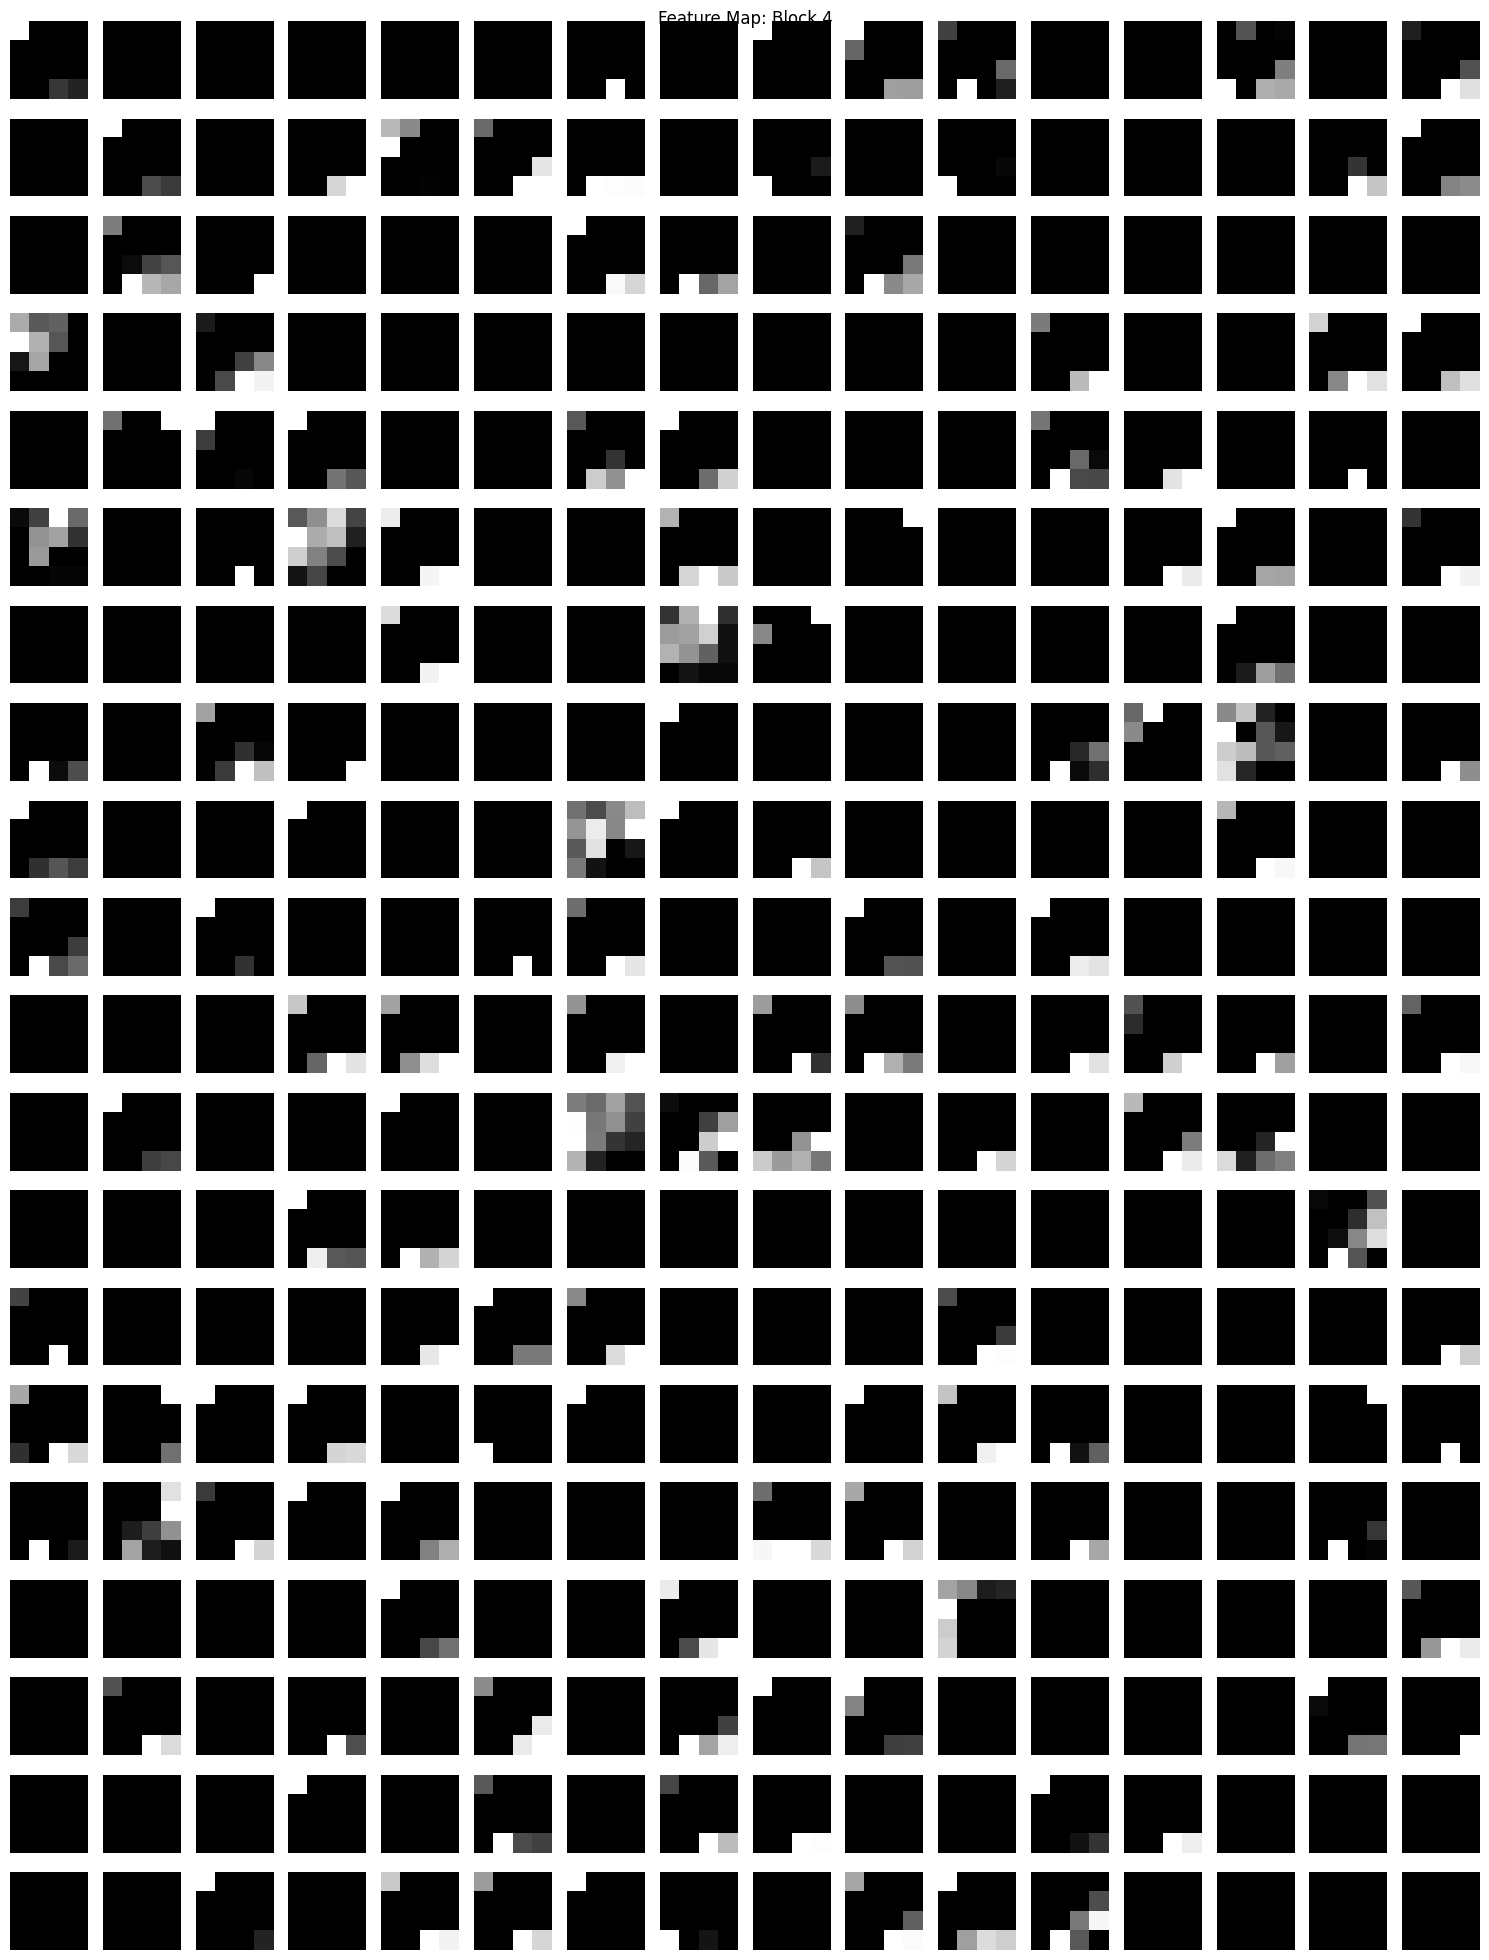

In [13]:
visualize_feature_maps(feature_maps, image_idx=1, num_blocks=5)

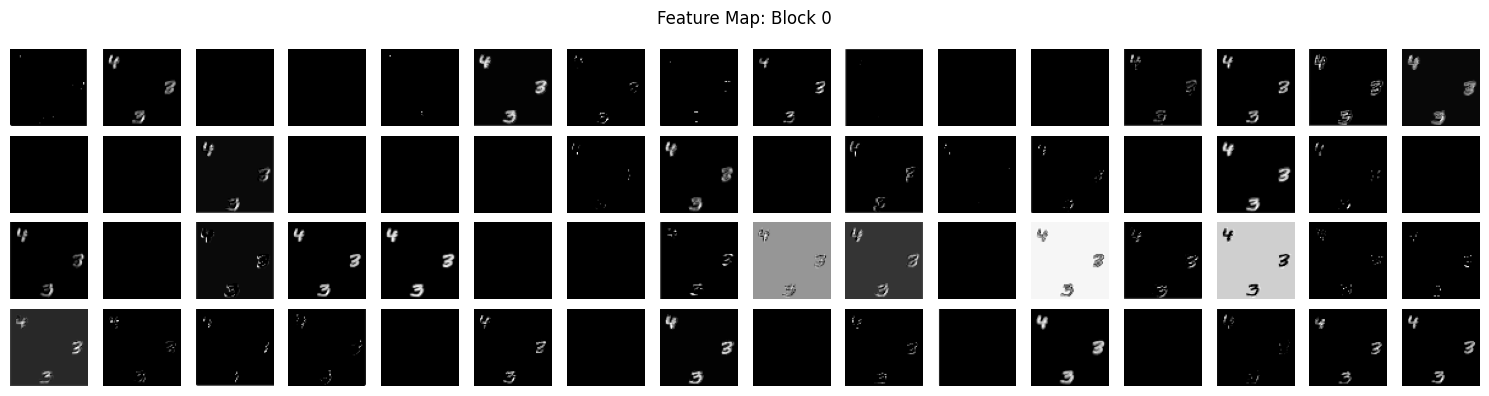

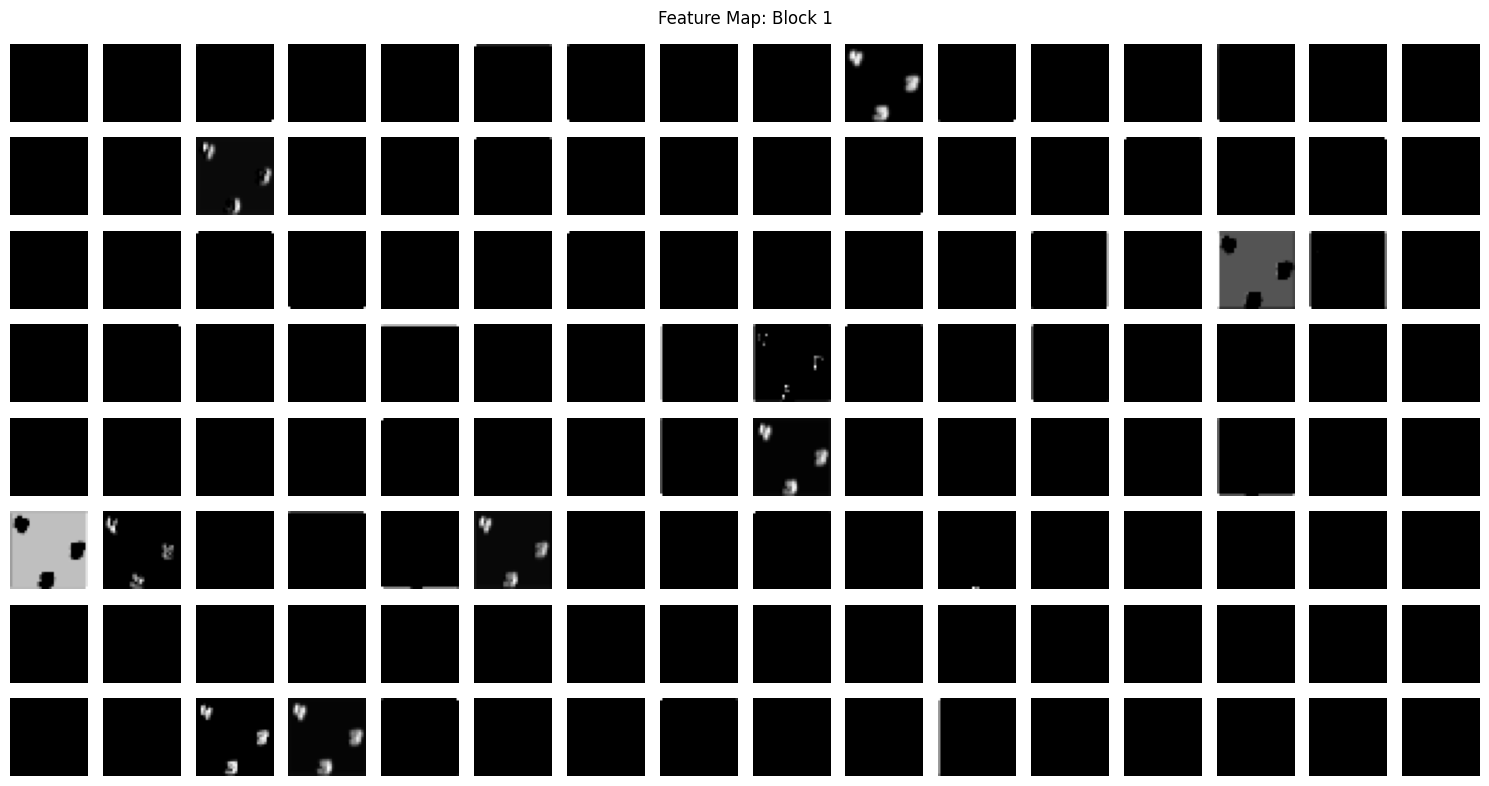

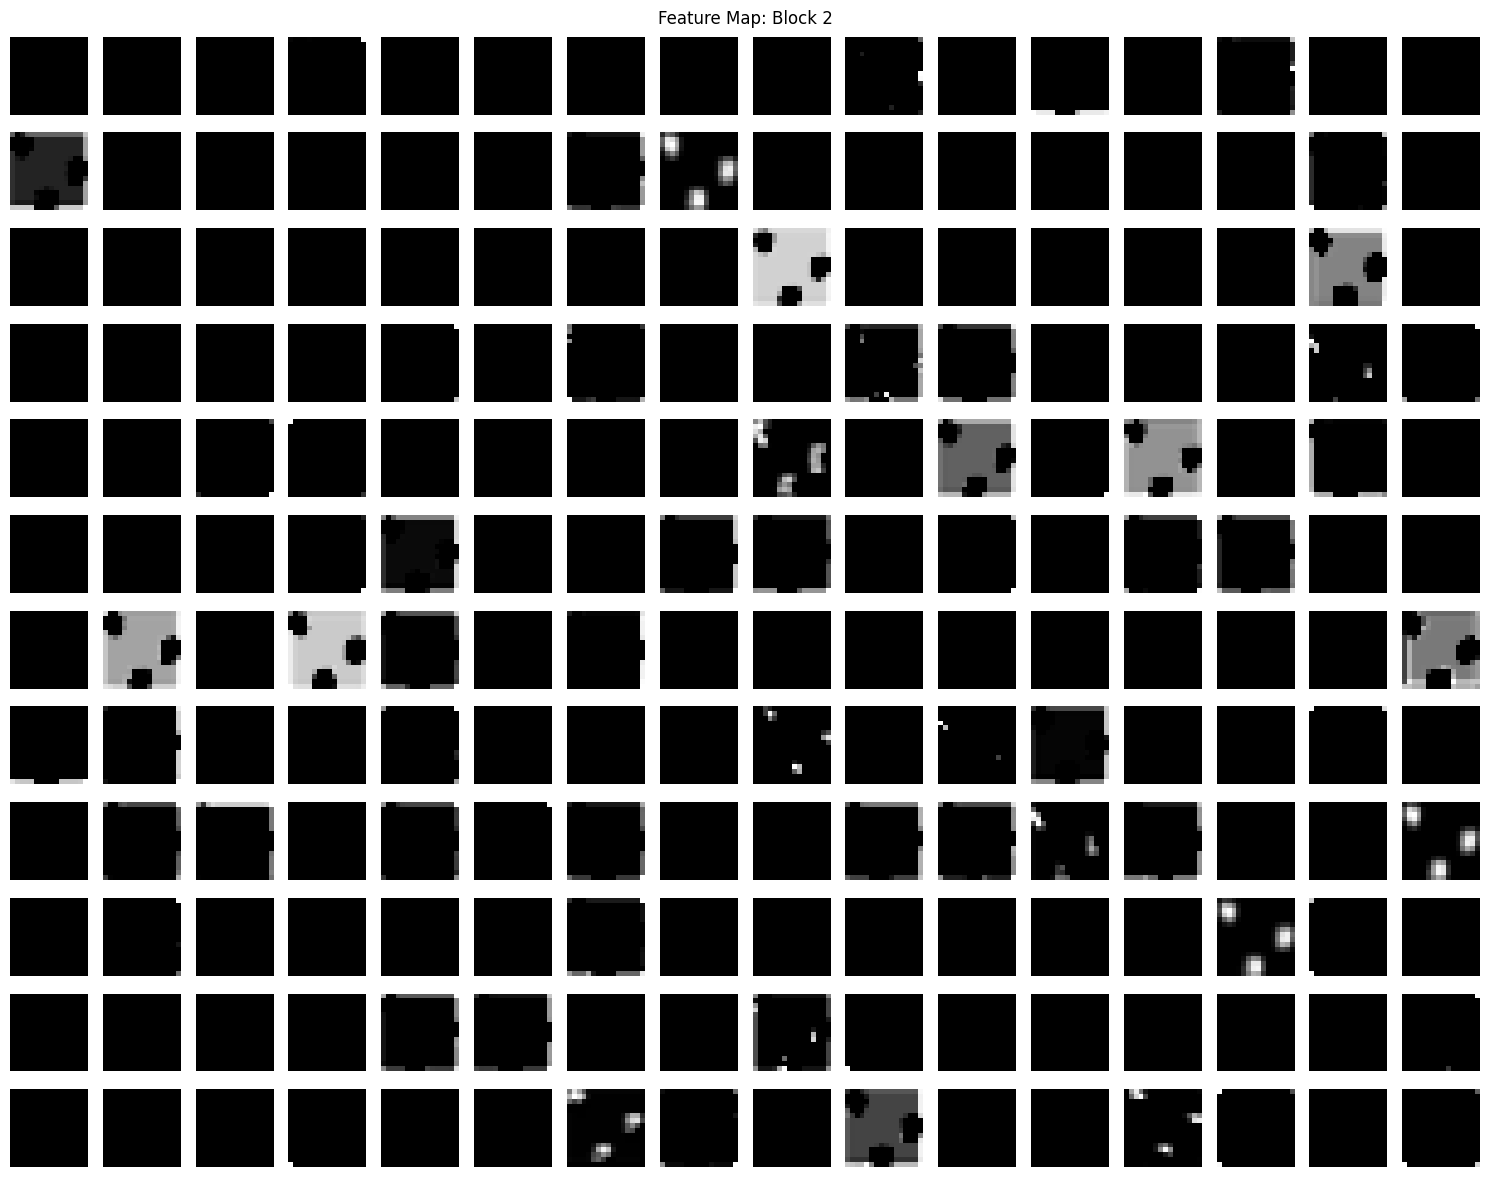

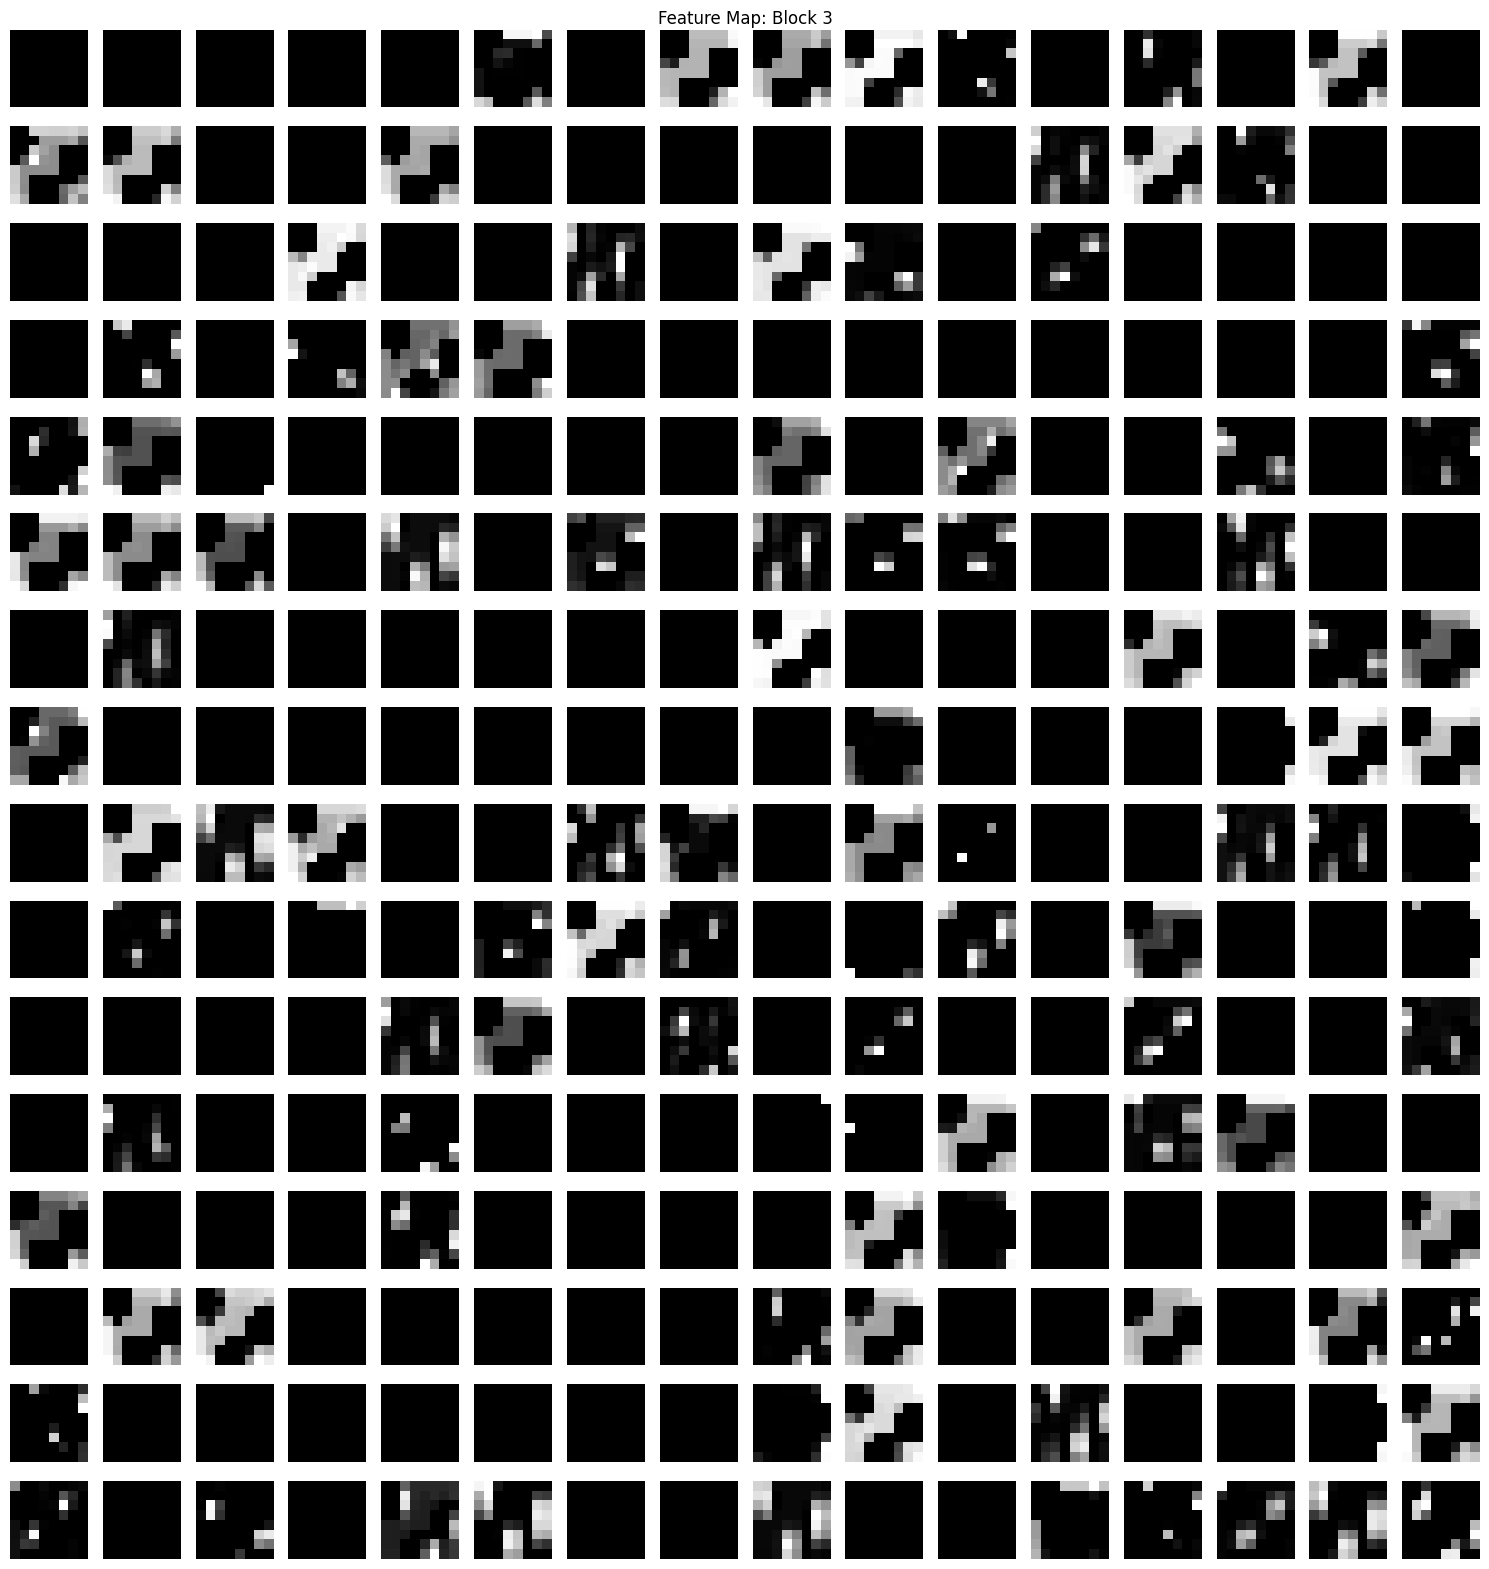

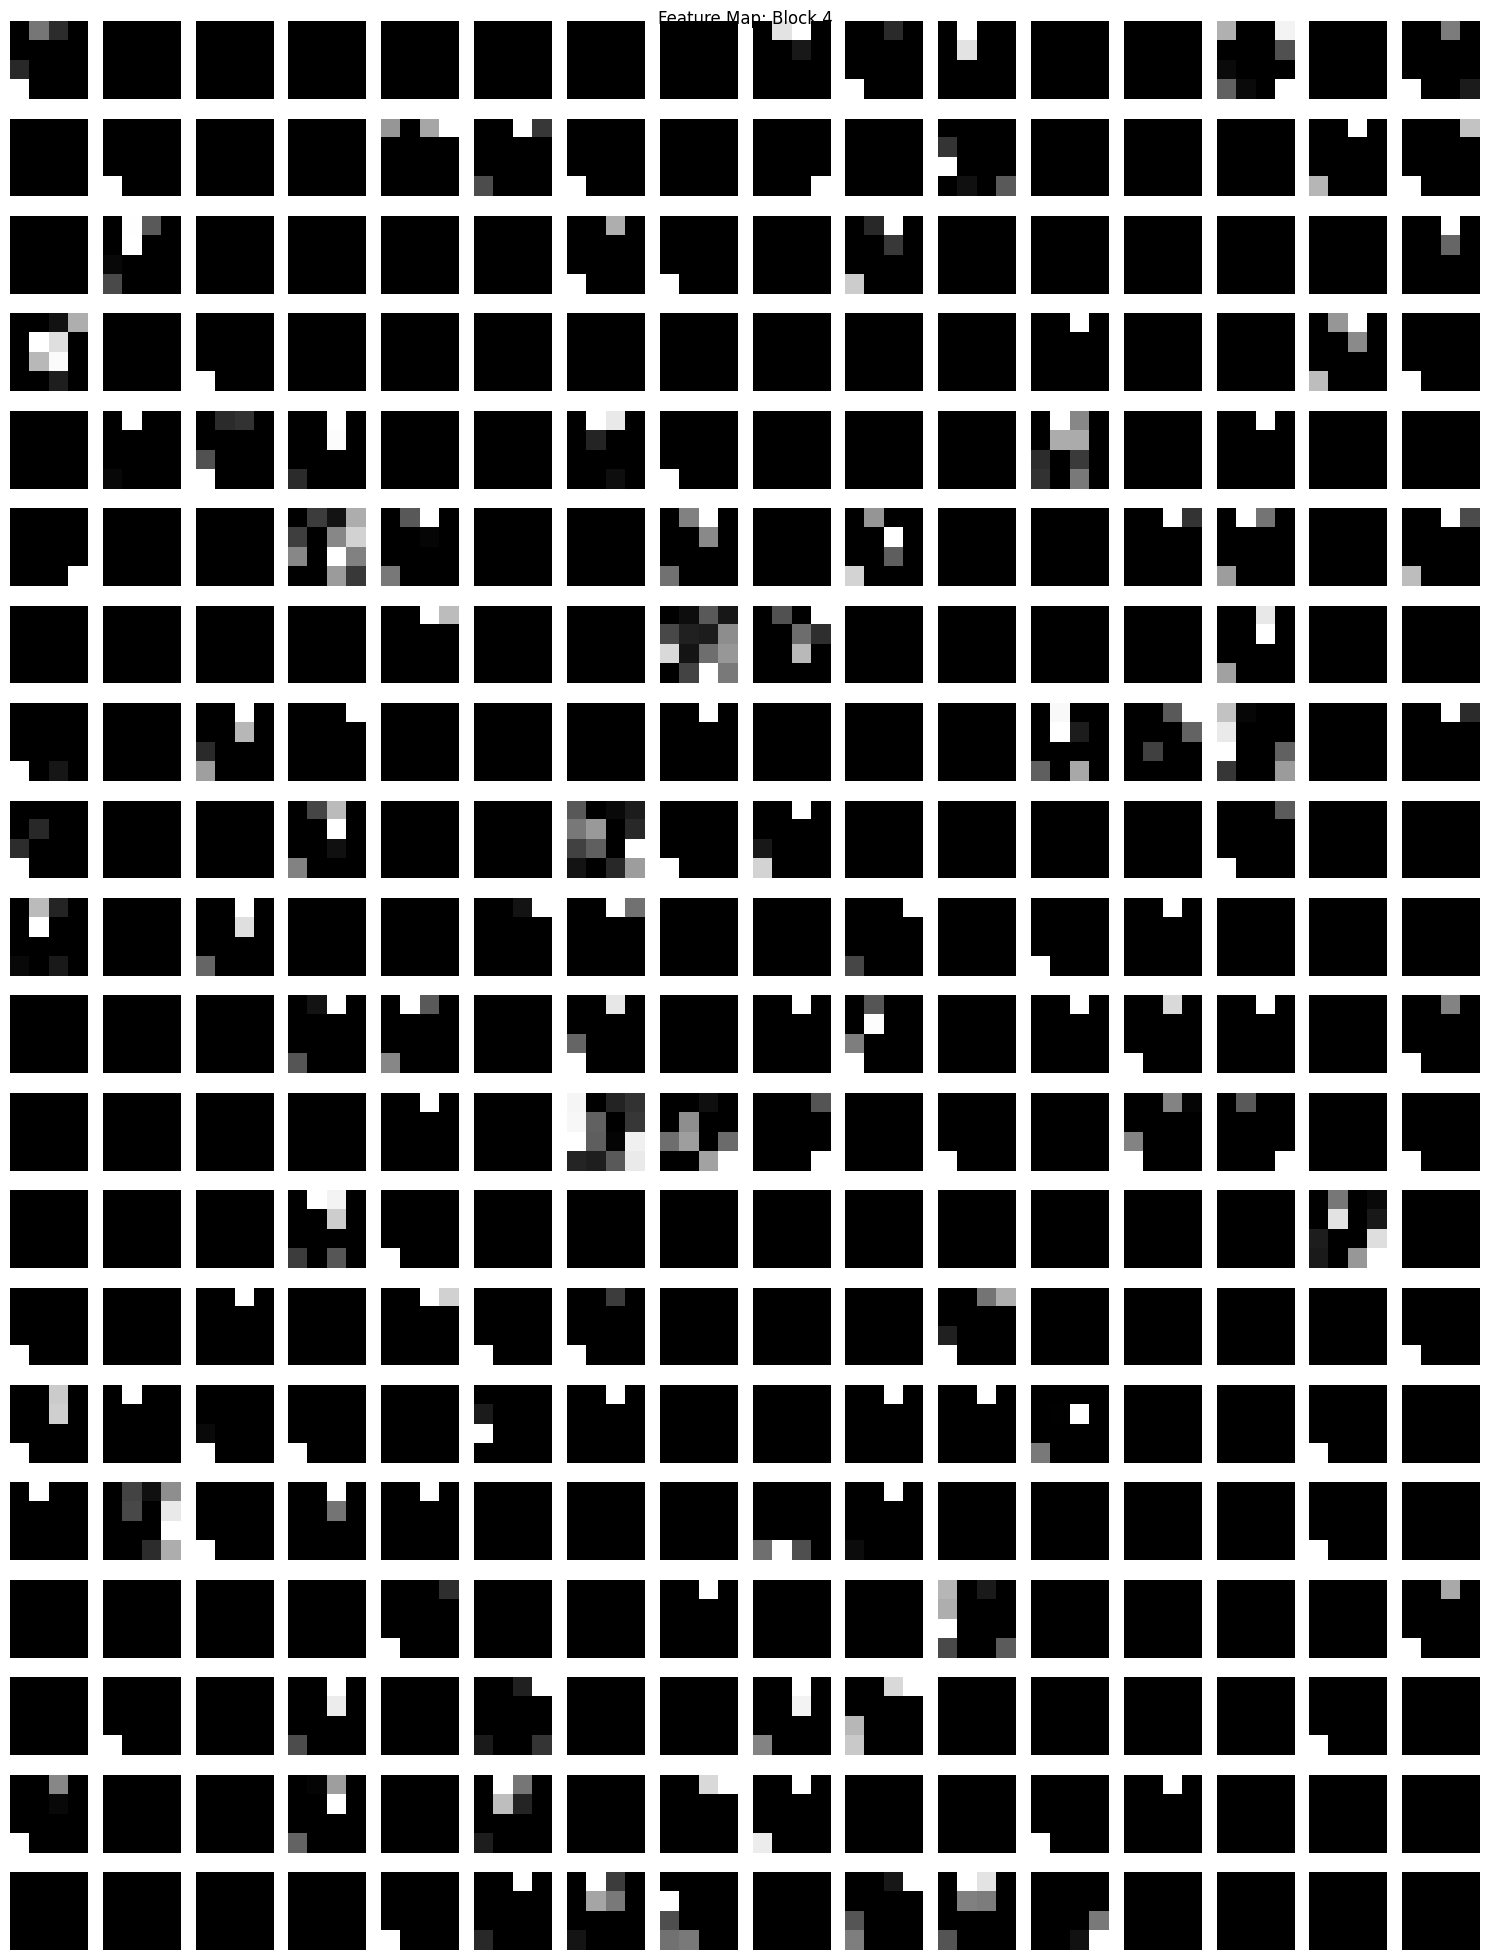

In [14]:
visualize_feature_maps(feature_maps, image_idx=2, num_blocks=5)

## Multi Label Classification

### Data Loading and Preprocessing

In [15]:
train_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'train', 'predict')
val_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'val', 'predict')
test_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'test', 'predict')

### Hyperparameter Tuning

In [16]:
# def multi_label_classification_train_worker():
#     train_worker(task='multi-label-classification')

# multi_label_classification_sweep_config = {
#     'name': 'multi-label-classification-hyperparameter-tuning',
#     'method': 'grid',
#     'metric': { 'name': 'val_loss', 'goal': 'minimize' },
#     'parameters': {
#         'dropout': { 'values': [0, 0.2, 0.4] },
#         'lr': { 'values': [1e-5, 1e-4] },
#         'num_blocks': { 'values': [2, 4] },
#         'optimizer': { 'values': ['sgd', 'adam'] },
#     }
# }

# multi_label_classification_sweep_id = wandb.sweep(multi_label_classification_sweep_config, project='smai-m24-cnn')
# wandb.agent(multi_label_classification_sweep_id, multi_label_classification_train_worker)
# wandb.finish()
# shutil.rmtree('wandb')

In [17]:
with open(f'{PROJECT_DIR}/assignments/4/results/cnn_multi_label_classification_hyperparameters.json', \
                                                                'r', encoding='utf-8') as file:
    config = json.load(file)

multi_label_cnn = CNN(
    task='multi-label-classification',
    activation='relu',
    pool='maxpool',
    dropout=config['dropout'],
    lr=config['lr'],
    num_blocks=config['num_blocks'],
    optimizer=config['optimizer']
)
multi_label_cnn.fit(train_dataset, val_dataset, verbose=True)
print()

train_pred = multi_label_cnn.predict(train_dataset)
train_exact_acc = (train_pred == train_dataset[:][1]).all(dim=1).float().mean()
train_hamming_acc = (train_pred == train_dataset[:][1]).float().mean()
print(f'Train exact match accuracy: {train_exact_acc}')
print(f'Train hamming accuracy: {train_hamming_acc}')

val_pred = multi_label_cnn.predict(val_dataset)
val_exact_acc = (val_pred == val_dataset[:][1]).all(dim=1).float().mean()
val_hamming_acc = (val_pred == val_dataset[:][1]).float().mean()
print(f'Validation exact match accuracy: {val_exact_acc}')
print(f'Validation hamming accuracy: {val_hamming_acc}')

test_pred = multi_label_cnn.predict(test_dataset)
test_exact_acc = (test_pred == test_dataset[:][1]).all(dim=1).float().mean()
test_hamming_acc = (test_pred == test_dataset[:][1]).float().mean()
print(f'Test exact match accuracy: {test_exact_acc}')
print(f'Test hamming accuracy: {test_hamming_acc}')

Epoch 0, Train Loss: 0.49045181902229484, Val Loss: 0.47697881379343093
Epoch 1, Train Loss: 0.46448779817160013, Val Loss: 0.4750206851340989
Epoch 2, Train Loss: 0.4575592367177082, Val Loss: 0.471443364218353
Epoch 3, Train Loss: 0.43672574171560063, Val Loss: 0.44257382426331654
Epoch 4, Train Loss: 0.39464111232818083, Val Loss: 0.37762672587872503
Epoch 5, Train Loss: 0.3536220673982262, Val Loss: 0.3415508031736108
Epoch 6, Train Loss: 0.311718654019881, Val Loss: 0.29308563549111183
Epoch 7, Train Loss: 0.2522525193198078, Val Loss: 0.23653849975225774
Epoch 8, Train Loss: 0.1903383881799158, Val Loss: 0.1839285981856866
Epoch 9, Train Loss: 0.1436846681733422, Val Loss: 0.15624830333554393

Train exact match accuracy: 0.8263491988182068
Train hamming accuracy: 0.9767618775367737
Validation exact match accuracy: 0.6303333044052124
Validation hamming accuracy: 0.9467333555221558
Test exact match accuracy: 0.5810869336128235
Test hamming accuracy: 0.9422174096107483
